<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import io

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set

For task 1 of Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains 18.800 binary images of handwritten characters of size (28,28). Each of these images depicts one of 893 different characters from 29 different alphabets. Each image is accompanied by a label that is encoded as an interger $y\in\{0, 1, ..., 892\}$ that indicate the caracter depicted in the image. The following cell provides code that loads the data from hardcoded URLs.

You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 


In [ ]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
# Downloading may take a while..
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/tvQmLyY7MhVsADb/download')
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/z234AHrQqx9RVGH/download')

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

train_x shape: (18800, 28, 28)
train_y shape: (18800,)



### Query data set

For this task you need to use the following query data set. The dataset contains 100 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 

Each test set consists of 1 query image and 5 candidate images. All images are the same size (28x28). The test data is organized in two numpy arrays. One for the query images with shape (100, 1, 28, 28) and another for the candidate imagaes with shape (100, 5, 28, 28). 

The task is to develop a model that enables selecting the image which is depicting the same character as the anchor image out of 5 test images. These test images are declared in the `query_x` numpy array . 

Finally, we plot the first 5 cases in the query dataset. The first column corresponds with the anchor images of each of the 5 cases. All other images are test images from which the task is to recognize the anchor image. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the anchor image. 

In [ ]:
query_dataset = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/YGn5gb7unBEuCLB/download")
queries_true = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/0sPeeIFB3W9RPZG/download")

queries, candidates_sets = np.split(query_dataset, [1], axis=1)

print(f"query images have shape: {queries.shape}")
print(f"target sets have shape: {candidates_sets.shape}")
print(f"ground truth: {queries_true.shape}")

query images have shape: (100, 1, 28, 28)
target sets have shape: (100, 5, 28, 28)
ground truth: (100,)


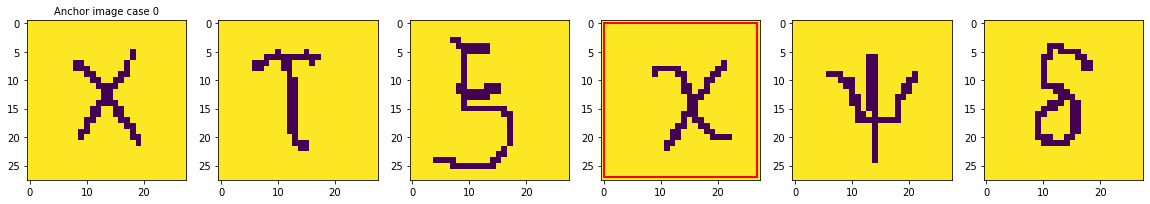

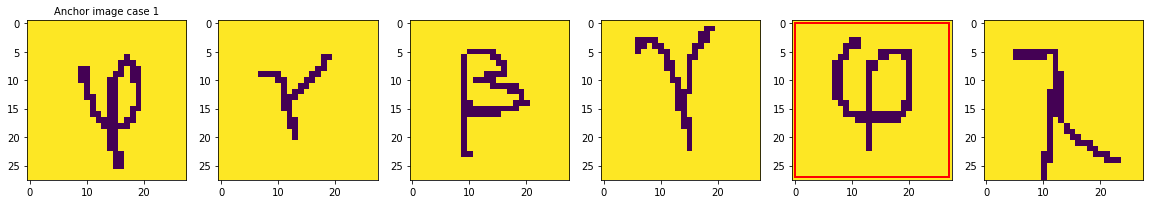

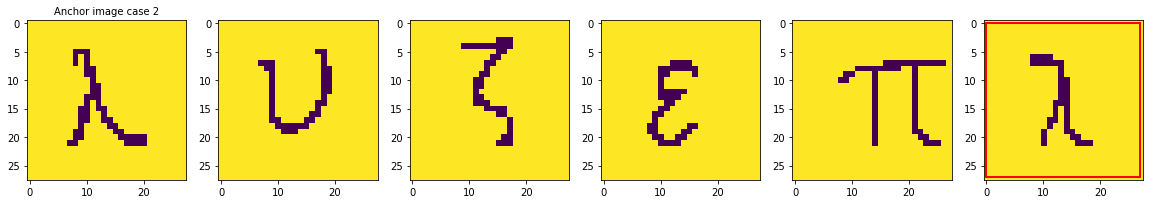

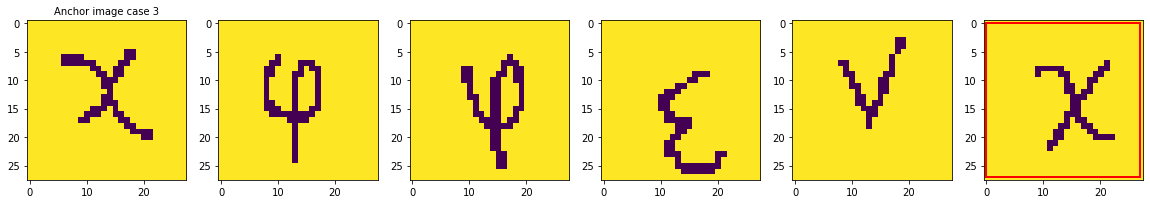

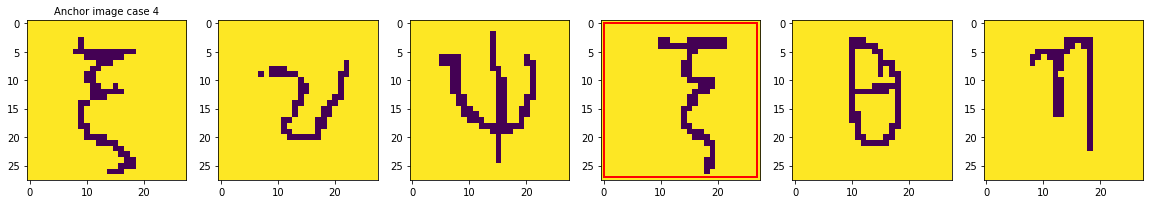

In [ ]:
from matplotlib.patches import Rectangle

def plot_case(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    
    
    
    
# plot the first five samples of the query datset
[plot_case(caseID) for caseID in range(5)] ;

In [ ]:
from tqdm import tqdm
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)
    
    return loss.item(), corrects, len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):
        
        
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
from sklearn.model_selection import train_test_split
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
train_x=train_x.astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0,stratify = train_y)
y_train=torch.from_numpy(y_train).to(dev)
x_train=torch.from_numpy(x_train).to(dev)
y_test=torch.from_numpy(y_test).to(dev)
x_test=torch.from_numpy(x_test).to(dev)

train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)
bs=64
train_dl, valid_dl = get_data(train_ds, test_ds, bs)



In [ ]:
print(type(x_train))

<class 'torch.Tensor'>


In [ ]:
from torch import nn
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
def preprocess(x):
    return x.view(-1, 1, 28, 28)
class test_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            Lambda(preprocess),
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
  

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d(1),
            Lambda(lambda x: x.view(x.size(0), -1)),

            #nn.Linear(2304, 1024),
            #nn.ReLU(inplace=True),
        )

        #self.last_layer = nn.Linear(1024, 965)
        self.last_layer = nn.Linear(2304, 1024)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = x.view(-1, 1, 28, 28)
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x




In [ ]:
from torch import optim
import torch.nn.functional as F

model = test_CNN()
model.to(dev)
epochs=28
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy


fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  4%|▎         | 1/28 [00:04<01:53,  4.20s/it]

EPOCH: 01/28 LOSS: 6.1262 ACC: 0.0279  VAL-LOSS: 4.8866 VAL-ACC: 0.0915 


  7%|▋         | 2/28 [00:08<01:47,  4.14s/it]

EPOCH: 02/28 LOSS: 3.8431 ACC: 0.1946  VAL-LOSS: 3.0926 VAL-ACC: 0.2957 


 11%|█         | 3/28 [00:12<01:42,  4.09s/it]

EPOCH: 03/28 LOSS: 2.3937 ACC: 0.4172  VAL-LOSS: 2.7887 VAL-ACC: 0.3590 


 14%|█▍        | 4/28 [00:16<01:37,  4.05s/it]

EPOCH: 04/28 LOSS: 1.6968 ACC: 0.5535  VAL-LOSS: 1.9429 VAL-ACC: 0.5202 


 18%|█▊        | 5/28 [00:20<01:32,  4.03s/it]

EPOCH: 05/28 LOSS: 1.2963 ACC: 0.6421  VAL-LOSS: 1.6957 VAL-ACC: 0.5644 


 21%|██▏       | 6/28 [00:24<01:28,  4.01s/it]

EPOCH: 06/28 LOSS: 1.0617 ACC: 0.6965  VAL-LOSS: 1.8936 VAL-ACC: 0.5543 


 25%|██▌       | 7/28 [00:28<01:23,  4.00s/it]

EPOCH: 07/28 LOSS: 0.8923 ACC: 0.7420  VAL-LOSS: 1.7580 VAL-ACC: 0.5662 


 29%|██▊       | 8/28 [00:32<01:19,  3.99s/it]

EPOCH: 08/28 LOSS: 0.7705 ACC: 0.7731  VAL-LOSS: 1.4781 VAL-ACC: 0.6311 


 32%|███▏      | 9/28 [00:35<01:15,  3.99s/it]

EPOCH: 09/28 LOSS: 0.6710 ACC: 0.8004  VAL-LOSS: 1.6923 VAL-ACC: 0.6114 


 36%|███▌      | 10/28 [00:39<01:11,  3.99s/it]

EPOCH: 10/28 LOSS: 0.6005 ACC: 0.8207  VAL-LOSS: 1.5722 VAL-ACC: 0.6383 


 39%|███▉      | 11/28 [00:43<01:07,  3.98s/it]

EPOCH: 11/28 LOSS: 0.5139 ACC: 0.8445  VAL-LOSS: 1.4021 VAL-ACC: 0.6747 


 43%|████▎     | 12/28 [00:47<01:03,  3.98s/it]

EPOCH: 12/28 LOSS: 0.4459 ACC: 0.8651  VAL-LOSS: 1.4826 VAL-ACC: 0.6660 


 46%|████▋     | 13/28 [00:51<00:59,  3.98s/it]

EPOCH: 13/28 LOSS: 0.4281 ACC: 0.8667  VAL-LOSS: 1.7112 VAL-ACC: 0.6569 


 50%|█████     | 14/28 [00:55<00:55,  3.97s/it]

EPOCH: 14/28 LOSS: 0.4188 ACC: 0.8717  VAL-LOSS: 1.6349 VAL-ACC: 0.6596 


 54%|█████▎    | 15/28 [00:59<00:51,  3.97s/it]

EPOCH: 15/28 LOSS: 0.3964 ACC: 0.8787  VAL-LOSS: 1.6251 VAL-ACC: 0.6614 


 57%|█████▋    | 16/28 [01:03<00:47,  3.97s/it]

EPOCH: 16/28 LOSS: 0.3536 ACC: 0.8927  VAL-LOSS: 1.6388 VAL-ACC: 0.6769 


 61%|██████    | 17/28 [01:07<00:43,  3.97s/it]

EPOCH: 17/28 LOSS: 0.3010 ACC: 0.9099  VAL-LOSS: 1.5898 VAL-ACC: 0.6779 


 64%|██████▍   | 18/28 [01:11<00:39,  3.97s/it]

EPOCH: 18/28 LOSS: 0.2885 ACC: 0.9086  VAL-LOSS: 1.6958 VAL-ACC: 0.6582 


 68%|██████▊   | 19/28 [01:15<00:35,  3.97s/it]

EPOCH: 19/28 LOSS: 0.2445 ACC: 0.9240  VAL-LOSS: 1.7416 VAL-ACC: 0.6689 


 71%|███████▏  | 20/28 [01:19<00:31,  3.97s/it]

EPOCH: 20/28 LOSS: 0.2305 ACC: 0.9295  VAL-LOSS: 1.9321 VAL-ACC: 0.6801 


 75%|███████▌  | 21/28 [01:23<00:27,  3.97s/it]

EPOCH: 21/28 LOSS: 0.2541 ACC: 0.9211  VAL-LOSS: 1.7953 VAL-ACC: 0.6859 


 79%|███████▊  | 22/28 [01:27<00:23,  3.98s/it]

EPOCH: 22/28 LOSS: 0.2310 ACC: 0.9297  VAL-LOSS: 1.6989 VAL-ACC: 0.6968 


 82%|████████▏ | 23/28 [01:31<00:19,  3.98s/it]

EPOCH: 23/28 LOSS: 0.1911 ACC: 0.9436  VAL-LOSS: 1.8670 VAL-ACC: 0.6737 


 86%|████████▌ | 24/28 [01:35<00:15,  3.98s/it]

EPOCH: 24/28 LOSS: 0.2070 ACC: 0.9352  VAL-LOSS: 1.8718 VAL-ACC: 0.6745 


 89%|████████▉ | 25/28 [01:39<00:11,  3.98s/it]

EPOCH: 25/28 LOSS: 0.1878 ACC: 0.9446  VAL-LOSS: 1.9281 VAL-ACC: 0.6944 


 93%|█████████▎| 26/28 [01:43<00:07,  3.98s/it]

EPOCH: 26/28 LOSS: 0.1876 ACC: 0.9439  VAL-LOSS: 1.8637 VAL-ACC: 0.7000 


 96%|█████████▋| 27/28 [01:47<00:03,  3.98s/it]

EPOCH: 27/28 LOSS: 0.1698 ACC: 0.9489  VAL-LOSS: 2.1577 VAL-ACC: 0.6832 


100%|██████████| 28/28 [01:51<00:00,  3.98s/it]

EPOCH: 28/28 LOSS: 0.1809 ACC: 0.9434  VAL-LOSS: 1.9968 VAL-ACC: 0.7043 


In [ ]:

def calculate_dis(query,candidates):
    query=query.astype(np.float32)
    query=torch.from_numpy(query).to(dev)
    candidates=candidates.astype(np.float32)
    candidates=torch.from_numpy(candidates).to(dev)
    #print(candidates_sets.shape)
    #print(query[0].shape)
    #q1=torch.tensor(query[0]) 
    count=0
    for i in range(0,len(queries)):
        #print(queries_true[i])
        q1=query[i]
        candidate=candidates[i]
        tensor1=model(q1)
        dist=[]
        for j in range(0,5):
            tensor2=model(candidate[j])
            dist.append(torch.sum((tensor1[0]-tensor2[0])**2).item())

        rank=[1,2,3,4,5]
        for l1 in range(0,4):
            for l2 in range(0,4-l1):
                #print(l2)
                if dist[l2]>dist[l2+1]:
                    n=dist[l2]
                    dist[l2]=dist[l2+1]
                    dist[l2+1]=n
                    n=rank[l2]
                    rank[l2]=rank[l2+1]
                    rank[l2+1]=n
        #print(rank)
        if rank[0]==queries_true[i]:
          count=count+1
        sorted_indexes=np.array(rank)
        #print(sorted_indexes)
 
calculate_dis(queries,candidates_sets)

In [ ]:
## #TODO Modify this function such that you implement you character recognition algorithm here
## The test code bellow will call this function with the following parameters 
## query - the query image (28, 28)
## candidates - numpy array of candidate images, shape (5, 28, 28)
## return - sorted array of the indexes of the images based on the similarty to the query image 
def test_model(query, candidates):
  # TODO: dummy output that should be substituted by values produced by your solution
    query=query.astype(np.float32)
    query=torch.from_numpy(query).to(dev)
    candidates=candidates.astype(np.float32)
    candidates=torch.from_numpy(candidates).to(dev)
    #print(candidates.shape)
    tensor1=model(query)
    dist=[]
    for j in range(0,5):
        tensor2=model(candidates[j])
        dist.append(torch.sum((tensor1[0]-tensor2[0])**2).item())
    rank=[1,2,3,4,5]
    for l1 in range(0,4):
        for l2 in range(0,4-l1):
            if dist[l2]>dist[l2+1]:
                n=dist[l2]
                dist[l2]=dist[l2+1]
                dist[l2+1]=n
                n=rank[l2]
                rank[l2]=rank[l2+1]
                rank[l2+1]=n
    sorted_indexes=np.array(rank)
    # print(dist)
    # print(sorted_indexes)
    return sorted_indexes

In [ ]:
## test top-1
def test_top_1(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return query_true == sorted_indexes[0]

## test top-3
def test_top_3(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return np.isin(query_true, sorted_indexes[:3])

top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
print(f"top-1 accuracy: {top_1}")

top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
print(f"top-3 accuracy: {top_3}")


top-1 accuracy: 0.91
top-3 accuracy: 0.99


In [ ]:
print(queries_true)

[3 4 5 5 3 1 4 4 5 5 2 2 4 5 5 1 3 1 5 3 1 4 4 1 3 2 4 4 4 3 3 2 4 2 2 5 1
 2 3 1 1 4 2 1 1 4 5 4 4 2 1 2 1 1 1 3 3 1 3 5 2 5 4 2 5 4 1 4 4 4 4 3 5 3
 4 4 1 4 4 1 3 1 2 1 3 5 4 5 3 1 4 3 1 4 2 1 1 2 3 1]


[7, 44, 56, 61, 63, 66, 69, 77, 78]
[4, 1, 3, 5, 2, 1, 4, 4, 4]
[2, 5, 2, 2, 5, 3, 1, 5, 2]


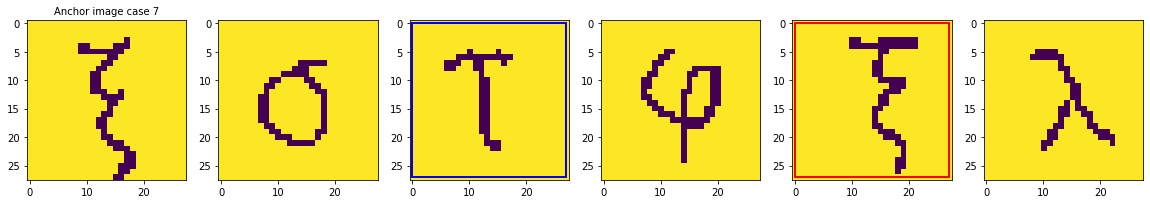

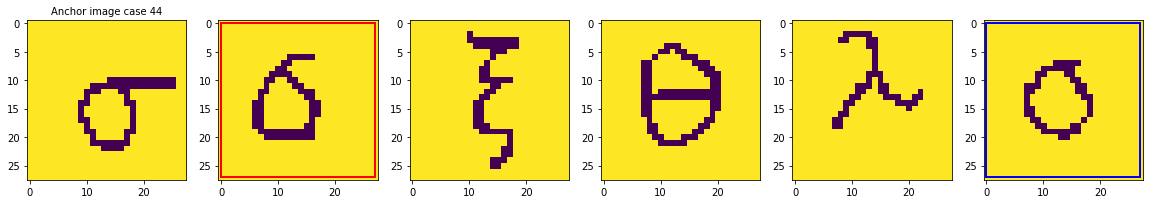

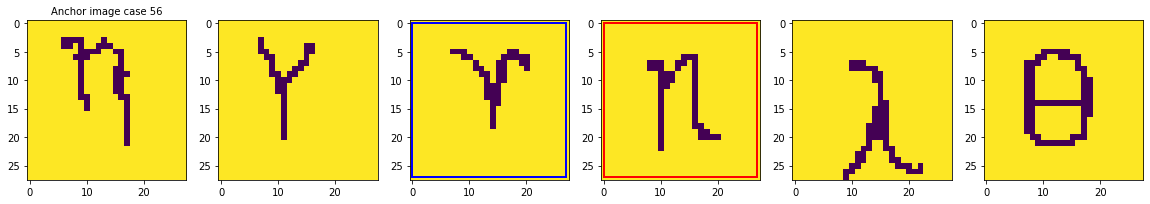

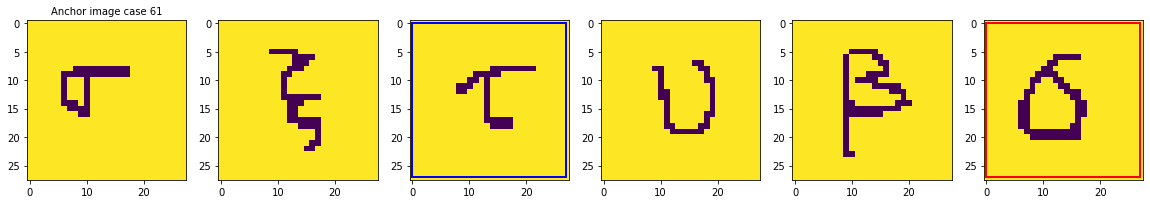

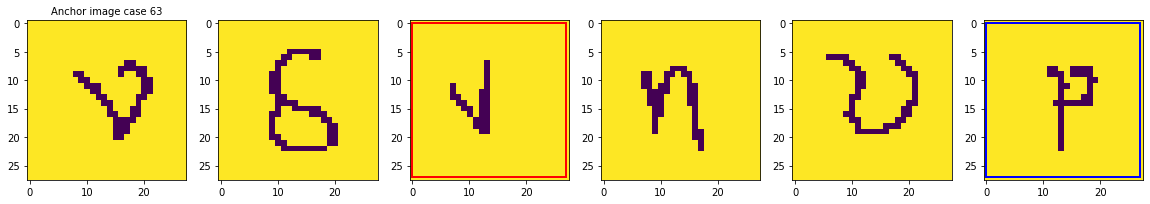

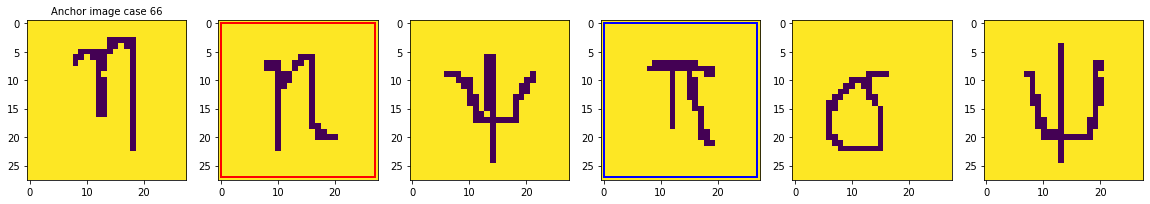

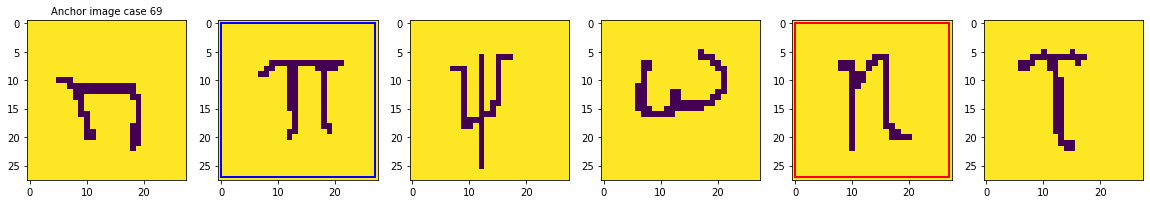

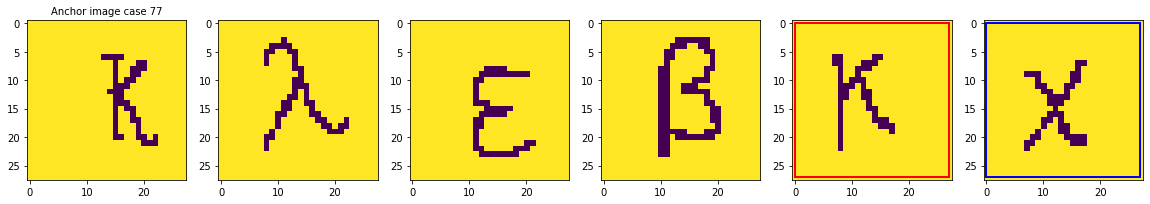

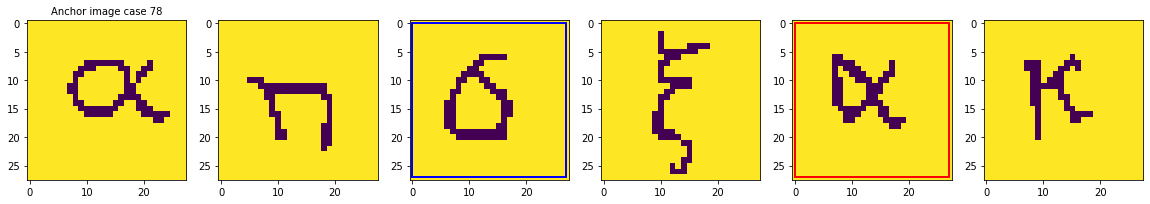

In [ ]:
count = 0
def search_false(query, candidates, query_true):
  sorted_indexes = test_model(query, candidates)
  return sorted_indexes[0]

def plot_cases(caseID, false_index):
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    axes[false_index].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='b',facecolor='none'))

false_result=[]
true_index=[]
false_index=[]
for (a, b, c) in zip(queries, candidates_sets, queries_true):
  count=count+1
  if test_top_1(a,b,c)==False:
    false_result.append(count-1)
    true_index.append(c)
    false_index.append(search_false(a,b,c))
    plot_cases(count-1,search_false(a,b,c))

print(false_result)
print(true_index)
print(false_index)

#[plot_cases(j,k-1) for (j,k) in zip(false_result,false_index)];